<a href="https://colab.research.google.com/github/wfwiggins/RSNA-NLP-2020/blob/master/RSNA20_NLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **RSNA 2020: Hands-on AI for Non-Coders**

## **Basics of Information Extraction from Radiology Reports**

In this demonstration, we will utilize techniques of _natural language processing_ (NLP) to train a classifier, which will analyze the text of radiology reports for chest radiographs to predict whether a report is **normal** or **abnormal**.

# System Setup & Downloading the Data

- The first step will install the necessary libraries, then the system will restart. This _WILL_ generate an error message, which can safely be ignored 😉.
- In the second step, we will download the [NLM Open-i "Indiana University Chest X-ray Reports" dataset](https://openi.nlm.nih.gov/faq#collection).

In [ ]:
#@title **Installing libraries & restarting...**

import os

!pip install fastai --upgrade >/dev/null
!pip install xmltodict >/dev/null

os.kill(os.getpid(), 9)

In [1]:
#@title **Downloading the data...**

!curl -s https://openi.nlm.nih.gov/imgs/collections/NLMCXR_reports.tgz | tar xvz >/dev/null

print('Success!')

Success!


# Reformatting the Data

Each of the reports is stored in _extensible markup language_ (XML) format. In order to work with the report text data more easily, we will extract the data and put it into a `pandas.DataFrame`, which is a tabular data structure.

The XML metadata contains [MeSH terms](https://www.ncbi.nlm.nih.gov/mesh/) for each report. We will use these to create the _label_ for each report in our dataset. These labels will serve as the targets for training our classifier to predict whether the report is **normal** or **abnormal**.

In [2]:
#@title **Extracting the data...**

import glob
import xmltodict
from fastai.basics import *

def xml_parse(f):
    with open(f) as xml:
        report_dict = xmltodict.parse(xml.read())
    xml.close()
    return report_dict

def get_label(report):
    label = L(report['eCitation']['MeSH']['major'])
    return 'normal' if label[0].lower() == 'normal' else 'abnormal'

def get_text(report):
    text_dict = {}
    text = report['eCitation']['MedlineCitation']['Article']['Abstract']['AbstractText']
    findings = text[2]['#text'] if '#text' in text[2] else ''
    text_dict['findings'] = findings
    impression = text[3]['#text'] if '#text' in text[3] else ''
    text_dict['impression'] = impression
    text_dict['text'] = ' '.join([findings, impression])
    return text_dict

def process_report(report):
    label = get_label(report)
    report_dict = get_text(report)
    report_dict['label'] = label
    return report_dict

fps = L(glob.glob('/content/ecgen-radiology/*'))
reports = fps.map(xml_parse)
reports_df = pd.DataFrame(reports.map(process_report))
reports_df

,findings,impression,text,label
0,No focal lung consolidation. Heart size and pulmonary vascularity are within normal limits. No pneumothorax or pleural effusion. Osseous structures are grossly intact.,No acute cardiopulmonary process.,No focal lung consolidation. Heart size and pulmonary vascularity are within normal limits. No pneumothorax or pleural effusion. Osseous structures are grossly intact. No acute cardiopulmonary process.,normal
1,"The heart, pulmonary XXXX and mediastinum are within normal limits. There is no pleural effusion or pneumothorax. There is no focal air space opacity to suggest a pneumonia. There is persistent stable appearing right apical scarring. There is persistent left basilar scarring. There are minimal degenerative changes of the spine.",Chronic lung disease without superimposed acute disease identified.,"The heart, pulmonary XXXX and mediastinum are within normal limits. There is no pleural effusion or pneumothorax. There is no focal air space opacity to suggest a pneumonia. There is persistent stable appearing right apical scarring. There is persistent left basilar scarring. There are minimal degenerative changes of the spine. Chronic lung disease without superimposed acute disease identified.",abnormal
2,XXXX XXXX and lateral views of the chest were obtained XXXX/XXXX. The lung volumes are low normal. The lungs are clear and there are no pleural effusions. The mediastinum and pulmonary XXXX are normal. The bony elements are not remarkable.,No acute cardiopulmonary abnormalities are seen. END OF REPORT.,XXXX XXXX and lateral views of the chest were obtained XXXX/XXXX. The lung volumes are low normal. The lungs are clear and there are no pleural effusions. The mediastinum and pulmonary XXXX are normal. The bony elements are not remarkable. No acute cardiopulmonary abnormalities are seen. END OF REPORT.,normal
3,,Right apical scarring as before. Right midlung granuloma. No suspicious appearing nodules identified. Well-expanded and clear lungs. Mediastinal contour within normal limits. No acute cardiopulmonary abnormality identified.,Right apical scarring as before. Right midlung granuloma. No suspicious appearing nodules identified. Well-expanded and clear lungs. Mediastinal contour within normal limits. No acute cardiopulmonary abnormality identified.,abnormal
4,No pneumothorax or pleural effusion. Normal cardiac contour. Clear lungs bilaterally.,1. No acute cardiopulmonary abnormalities.,No pneumothorax or pleural effusion. Normal cardiac contour. Clear lungs bilaterally. 1. No acute cardiopulmonary abnormalities.,normal
...,...,...,...,...
3950,Again seen are platelike horizontal opacities in both lung bases through this is consistent with scarring or subsegmental atelectasis. There are T-spine osteophytes. The cardiomediastinal silhouette and pulmonary vasculature are within normal limits. There is no pneumothorax or pleural effusion. There there is no lobar pneumonia. There are calcified right hilar granuloma. There are degenerative changes of the XXXX. There is a curvilinear density within and along the right costophrenic sulcus which most XXXX represents a skinfold. There is a unchanged fracture with callus at the left 9th la...,Unchanged platelike bibasilar opacities most XXXX representing scarring or subsegmental atelectasis. No acute cardiopulmonary abnormality.,Again seen are platelike horizontal opacities in both lung bases through this is consistent with scarring or subsegmental atelectasis. There are T-spine osteophytes. The cardiomediastinal silhouette and pulmonary vasculature are within normal limits. There is no pneumothorax or pleural effusion. There there is no lobar pneumonia. There are calcified right hilar granuloma. There are degenerative changes of the XXXX. There is a curvilinear density within and along the right costophrenic sulcus which most XXXX represents a skinfold. There is a unchanged fracture with callus at the left 9th la...,abnormal
3951,Heart size and pulmona

# Exploring the data

As you'll see in the table above, there are some reports where the "Impression" states something along the lines of "No acute cardiopulmonary abnormality" but the label is "abnormal". This is usually due to a chronic incidental finding or artifact that is mentioned in the "Findings", but isn't included in the "Impression".

> We'll revisit this point later when we're deciding which text from the report we want to use to train our classifier.

For now, let's look through a little more of the data and see how many normals and abnormals we have to work with.

In [3]:
#@title **Run this cell several times to view random samples of the data**

reports_df.sample(5)

,findings,impression,text,label
1036,"The lungs are clear bilaterally. Specifically, no evidence of focal consolidation, pneumothorax, or pleural effusion.. Cardio mediastinal silhouette is unremarkable. Visualized osseous structures of the thorax are without acute abnormality.",No acute cardiopulmonary abnormality..,"The lungs are clear bilaterally. Specifically, no evidence of focal consolidation, pneumothorax, or pleural effusion.. Cardio mediastinal silhouette is unremarkable. Visualized osseous structures of the thorax are without acute abnormality. No acute cardiopulmonary abnormality..",normal
500,,,,normal
960,Heart size and vascularity normal. These contour normal. Lungs clear. No pleural effusions or pneumothoraces.,Normal chest.,Heart size and vascularity normal. These contour normal. Lungs clear. No pleural effusions or pneumothoraces. Normal chest.,normal
2376,There are scattered XXXX opacities in the left lower lobe. Cardiac silhouette is within normal limits. There is prominence of the right and left hilum XXXX representing enlargement of the central pulmonary arteries. No pneumothorax or pleural effusion. No acute bone abnormality.,1. Left lower lobe opacities XXXX representing pneumonia. 2. Enlargement of the central pulmonary arteries raising the question of pulmonary hypertension.,There are scattered XXXX opacities in the left lower lobe. Cardiac silhouette is within normal limits. There is prominence of the right and left hilum XXXX representing enlargement of the central pulmonary arteries. No pneumothorax or pleural effusion. No acute bone abnormality. 1. Left lower lobe opacities XXXX representing pneumonia. 2. Enlargement of the central pulmonary arteries raising the question of pulmonary hypertension.,abnormal
3774,"Coronary artery stents visualized. The cardiomediastinal silhouette is within normal limits for size and contour. The lungs are normally inflated without evidence of focal airspace disease, pleural effusion, or pneumothorax. No acute bone abnormality.",No acute cardiopulmonary process.,"Coronary artery stents visualized. The cardiomediastinal silhouette is within normal limits for size and contour. The lungs are normally inflated without evidence of focal airspace disease, pleural effusion, or pneumothorax. No acute bone abnormality. No acute cardiopulmonary process.",abnormal


Here are some of the things you may have noticed about the data, as you reviewed it:
- Some reports only have an Impression (i.e. no separate Findings section)
- Many reports contain blocks of "XXXX" text. This is due to the fact that these reports were anonymized prior to releasing them as an open data set. These blocks likely represent _named entities_ or dates.
- As expected, there is wide variation in the length of these chest radiograph reports.

<hr>

Next, let's count how many of each label we have.


Abnormal: 2564
Normal: 1391



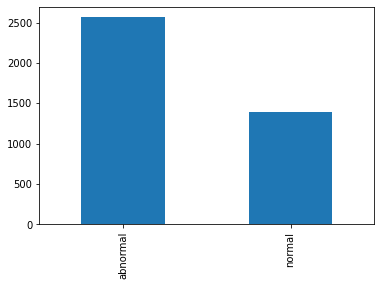

In [4]:
#@title **Label counts: # of Normals & Abnormals**
label_counts = reports_df.label.value_counts()
print('Abnormal:', label_counts['abnormal'])
print('Normal:', label_counts['normal'])
print()
label_counts.plot.bar();

As we see in the bar graph above, there are almost twice as many abnormal reports as there are normal reports. This will be important to remember as we partition our data into training, validation, and test sets.

In fact, we'll go ahead and split off ("hold out") the test set right now to ensure our model is not exposed to it until the very end. 

We'll set it up such that the our test set is 15% of our full data set and keep the relative percentage of labels the same as in our full dataset.

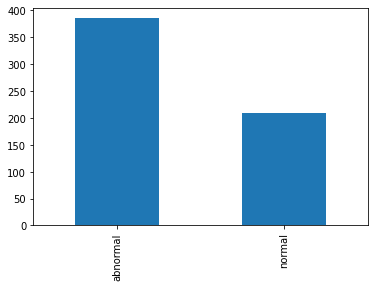

In [5]:
#@title **Test set label counts**
from sklearn.model_selection import train_test_split

np.random.seed(42)

train_val, test = train_test_split(reports_df, test_size=0.15, stratify=reports_df.label.values)
train_val.reset_index(inplace=True)
test.reset_index(inplace=True)
test_counts = test.label.value_counts()
test_counts.plot.bar();

# Language Modeling

The types of algorithms we use in NLP work with with numbers, not text. Therefore, we need a way to convert text into numbers.

## Tokenization

_Tokenization_ is the process by which we split text into chunks or _tokens_. An individual token could be a sentence or phrase, a word, a part of a word, or a single character. Most often, we choose to tokenize at the word or sub-word level.

Each token is assigned a sequential integer value and the collection of token-integer pairs is called our _vocabulary_.

## Embedding

While these integers map one-to-one onto our tokens, their numeric value is otherwise meaningless. To embed more information into the numeric representation of our tokens, we employ a process called _language modeling_. We can either use a pre-trained language model for this _embedding_ or we can fine-tune a language model to better model our "radiology language". This latter process is called _transfer learning_.

In [6]:
#@title **Word Tokenization**

from fastai.text.all import *

spacy = WordTokenizer()
text = train_val.loc[0, 'text']
print('Original text:')
print(text)
print()
tkns = first(spacy([text]))
print('After word tokenization (only showing first 10 tokens):')
print(coll_repr(tkns))

Original text:
The heart size is normal. There is normal cardiomediastinal silhouette. Lungs are clear bilaterally. Thoracic spine shows anterior osteophyte formation. No acute cardiopulmonary abnormality.

After word tokenization (only showing first 10 tokens):
(#29) ['The','heart','size','is','normal','.','There','is','normal','cardiomediastinal'...]


In [7]:
#@title **fast.ai Tokenization**

tkn = Tokenizer(spacy)
toks = tkn(text)
print(coll_repr(toks, 15))

(#35) ['xxbos','xxmaj','the','heart','size','is','normal','.','xxmaj','there','is','normal','cardiomediastinal','silhouette','.'...]


## Added features from fast.ai

You'll notice some odd-appearing tokens in the above output. These are special tokens that indicate certain things about the text.
- `'xxbos'` indicates the beginning of the text _stream_
- `'xxmaj'` indicates that the following character was capitalized before fast.ai lowered it

These special tokens enrich the data while reducing the vocab by eliminating redundant upper and lower case variants of individual words.

## Numericalization

Now that we've converted our text to tokens, the next step in embedding is to convert each unique token to a number.

For language modeling, we can do this on all of the text that we intend to use for training and validation. So we'll combine the **Findings** and **Impression** for each of our reports and tokenize the text to define our _vocabulary_. Each token in the vocabulary will be identified by a unique number.

In [8]:
#@title **Computing vocabulary...**

txts = L(train_val['text'].to_list())
toks = txts.map(tkn)
num = Numericalize()
num.setup(toks)
coll_repr(num.vocab, 20)

"(#1168) ['xxunk','xxpad','xxbos','xxeos','xxfld','xxrep','xxwrep','xxup','xxmaj','.','no','the','is','are','normal',',','4','x','and','of'...]"

As you can see above, we have 1,168 tokens in our vocabulary. The special tokens from `fast.ai` appear first, followed by every other token in order of decreasing frequency. By default, `fast.ai` only includes tokens that appear at least 3 times in the _corpus_ (collection of texts). 

In [9]:
#@title **Numericalizing tokens...**

nums = num(toks[0][:14])
print(nums)
print(' '.join(num.vocab[i] for i in nums))

TensorText([ 2,  8, 11, 24, 28, 12, 14,  9,  8, 25, 12, 14, 47, 42])
xxbos xxmaj the heart size is normal . xxmaj there is normal cardiomediastinal silhouette


Here, we see a subset of the numericalized tokens (top) with their corresponding word tokens (bottom) from the first report in our _corpus_. 

## Language Model Transfer Learning

By default, `fastai.text` uses a language model pre-trained on the WikiText-103 corpus, which is a frequently used benchmark for NLP models, similar to ImageNet for image classification models.

In their 2018 ACL paper "[Universal Language Model Fine-Tuning for Text Classification](https://arxiv.org/abs/1801.06146)", Jeremy Howard and Sebastian Ruder proposed the ULM-FiT approach of fine-tuning the language model on the corpus on which we will train our text classification model.

Here, we will fine-tune the language model in two stages.

In [10]:
#@title **Fine-tuning the language model (part 1)...**

dls_lm = TextDataLoaders.from_df(train_val, valid_pct=0.3, seed=42, text_col='text', is_lm=True)
learn = language_model_learner(dls_lm, AWD_LSTM, metrics=[accuracy, Perplexity()]).to_fp16()
learn.fit_one_cycle(1, 2e-2)

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,3.630922,2.322998,0.516553,10.206223,00:20


In [12]:
#@title **Fine-tuning the language model (part 2)...**

learn.unfreeze()
learn.fit_one_cycle(10, 2e-3)

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,2.556715,2.085403,0.554155,8.047837,00:24
1,2.361071,1.858963,0.591483,6.417082,00:24
2,2.173694,1.708058,0.620550,5.518234,00:24
3,1.993125,1.587987,0.643873,4.893888,00:24
4,1.855278,1.529404,0.655503,4.615426,00:24
5,1.741695,1.494283,0.666212,4.456140,00:24
6,1.645422,1.466133,0.671289,4.332448,00:24
7,1.571282,1.453746,0.673462,4.279114,00:24
8,1.506127,1.444926,0.676284,4.241539,00:24
9,1.469286,1.444167,0.676613,4.238319,00:24


In [13]:
#@title **Saving the fine-tuned language model...**

learn.save_encoder('fine-tuned')

In [14]:
#@title **Downloading fine-tuned language model...**

!wget -q https://github.com/wfwiggins/RSNA-NLP-2020/blob/master/models.zip?raw=true
!mkdir -p models
!unzip -o models.zip?raw=true -d models >/dev/null
!rm models.zip?raw=true

print('Success!')

Success!
